**NOTE**: use jupyter classic notebook rather than jupyterlab as not all features are supported in jupyterlab yet

Read data from the PMS over serial. I want to convert the keys using the following mapping:

In [1]:
key_map = {
    "a":"particles_03um",
    "b":"particles_05um",
    "c":"particles_10um",
    "d":"particles_25um",
    "e":"particles_50um",
    "f":"particles_100um"
}

In [2]:
import serial
import time
import datetime
import json
import pandas as pd
%matplotlib inline

In [3]:
!ls /dev/tty.*

/dev/tty.Bluedio-BluetoothSerial /dev/tty.RobinsiPhone6-Wirelessi
/dev/tty.Bluetooth-Incoming-Port /dev/tty.usbmodem141401


In [4]:
port = '/dev/tty.usbmodem141401'

In [5]:
ser = serial.Serial(port)

In [6]:
data_json = ser.readline().decode("utf-8").replace("\r\n", "") 

In [7]:
data_dict = json.loads(data_json)

In [8]:
data_dict

{'a': 1056, 'b': 306, 'c': 31, 'd': 1, 'e': 1, 'f': 0}

Use the key map to recover accurate keys

In [9]:
mapped_data_dict = {key_map[key]:val for key, val in data_dict.items()}

In [10]:
mapped_data_dict

{'particles_03um': 1056,
 'particles_05um': 306,
 'particles_10um': 31,
 'particles_25um': 1,
 'particles_50um': 1,
 'particles_100um': 0}

In [11]:
pd.Series(mapped_data_dict)

particles_03um     1056
particles_05um      306
particles_10um       31
particles_25um        1
particles_50um        1
particles_100um       0
dtype: int64

Lets wrap this in a small class

In [12]:
class pmsreader():
    def __init__(self, port='/dev/tty.usbmodem141401'):
        self._ser = serial.Serial(port)
    
    def read(self):
        try:
            data_json = self._ser.readline().decode("utf-8").replace("\r\n", "") 
            data_dict = json.loads(data_json)
            mapped_data_dict = {key_map[key]:val for key, val in data_dict.items()}
            mapped_data_dict['time'] = datetime.datetime.now()
            return mapped_data_dict
        except:
            return None        

In [13]:
pms = pmsreader()

In [14]:
pms.read()

{'particles_03um': 924,
 'particles_05um': 263,
 'particles_10um': 27,
 'particles_25um': 0,
 'particles_50um': 0,
 'particles_100um': 0,
 'time': datetime.datetime(2018, 10, 31, 7, 59, 52, 577380)}

Now capture some time-series data

In [15]:
data = []
measurements = 30
sleep_sec = 2

for i in range(measurements):
    reading = pms.read()
    if reading is not None:
        data.append(reading)
    time.sleep(sleep_sec)

In [16]:
df = pd.DataFrame(data)
df.set_index('time', inplace=True)

In [17]:
df.head()

,particles_03um,particles_05um,particles_100um,particles_10um,particles_25um,particles_50um
time,,,,,,
2018-10-31 07:59:58.270981,924,263,0,27,0,0
2018-10-31 08:00:00.272154,933,268,0,27,0,0
2018-10-31 08:00:02.274986,933,268,0,27,0,0
2018-10-31 08:00:04.281160,933,268,0,27,0,0
2018-10-31 08:00:06.286794,969,280,0,24,0,0


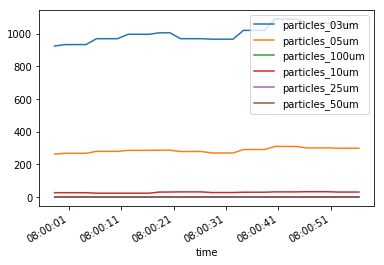

In [18]:
df.plot()

## Streamz
Rather than accumulating data then producing a static plot, we want to display a live stream of data. To do so we can use:
* https://streamz.readthedocs.io/en/latest/index.html
* http://pyviz.org/tutorial/11_Streaming_Data.html